# Neural Network

For this project, I've built a multi-class, neural network with various hyperparameters. For demonstration purposes, my neural network will be learning to discern spam from ham text messages. The dataset I'll be using was downloaded from: https://www.kaggle.com/rushirdx/spam-and-ham-dataset

## Step 1: Loading in Packages, Module, and Dataset

**run modules/venv_setup.ipynb**

As I'm using Gradient, a cloud computing service, "venv_setup.ipynb" was created to avoid having to redownload the necessary packages every session. It first downloads the packages to a separate folder called "envs." It then adds "envs" to conda's directory and prompts the user to restart the kernel. If the packages have already been downloaded (e.g. during a previous session), it'll give the user the option to skip the download and will simply add "envs" to conda's directory.

**run modules/data_loader.ipynb**

"data_loader.ipynb" takes "spam.csv," splits the dataset (n=5572) into training (n=3733) and test set (n=1839), then vectorizes each text message using Sklearn's TfidVectorizer with 'max df' and 'min df' set to 0.95 and 2, respectively.

**run modules/results_func.ipynb**

Most of the results have been collected ahead of time and are being called by the functions in "results_func.ipynb." If you would like to download the saved pickle files, please refer to the folder, "saved_data," which includes the pickle files along the script that generated them.

In [ ]:
run modules/venv_setup.ipynb

Download packages from requirements.txt to current project environment? [y/n] n


added /notebooks/envs
completed operation for: /notebooks/envs

Please restart the kernel to use updated packages


Restart kernel to use updated packages? [y/n] y


Restarting kernel


In [ ]:
run modules/module.ipynb

In [ ]:
run modules/model.ipynb

In [ ]:
run modules/data_loader.ipynb

In [ ]:
run modules/results_func.ipynb

## Step 2: A Quick Glance

Now that we've loaded everything in, let's take a quick look at the dataset.

In [ ]:
df.head()

,label,msg
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
len(df) # number of observations

5572

In [ ]:
step2() # an example of ham and spam
# please refer to results_func.ipynb


#155 ham = Aaooooright are you at work?

#2 spam = Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



In [ ]:
df['label'].value_counts(normalize=True)

ham     0.865937
spam    0.134063
Name: label, dtype: float64

We have an assortment of text messages. You have your standard spam and ham alongside seemingly spam hams and ham spams. It'll be interesting to see if the neural network is able to accurately label these misleading examples. We also see that there are far more ham messages than spam messages. Only 13% of the total dataset is spam, making our predictions susceptible to type II error (false negatives). Depending on the results, we may need to adjust the prediction threshold using an F-score.

## Step 2: Gradient Checking

Before training any neural network, it's always a good idea to implement gradient checking. The gradient checking function below uses a two-sided limit with an epsilon value of 1e-7 to get an approximation of the gradient. Therefore, the difference between the approximated gradient and the gradient derived from backpropagation should be less than 1e-7. We'll also be using the function new_test(X, grad_check = False) to reset the parameters and the random seed so anyone following along sees the same results. For gradient checking, we’ll use a small model with one hidden layer and two nodes as it's a very time-consuming process. Along a smaller model, we'll also be using a smaller dataset of only a 100 training examples. The parameters have been initialized using the method outlined by He et al. (2015). By doing so, we're less likely to experience exploding or vanishing gradients during training.

*For subsequent steps, we'll be using a larger model with 2 hidden layers with 500 nodes each.*

In [ ]:
X_check = X_train[:100, :].copy()
y_check = y_train[:100, :].copy()

#### Gradient checking without regularization

In [ ]:
grad_check_params, grad_check_layers = new_test(X_check, grad_check = True)

AL, cache, cost = forward_prop(X_check, y_check, grad_check_params, lambda_value=0)
grad_check_grads = back_prop(AL, X_check, y_check, grad_check_layers, cache, lambda_value=0)

diff_noreg,_,_ = grad_check(X_check, y_check, grad_check_params, grad_check_grads, lambda_value=0, epsilon=1e-7)

grad check: 100%|██████████| 5923/5923 [00:22<00:00, 264.76it/s]

All good! Difference is = 8.972540135680432e-09


#### Gradient checking with regularization

In [ ]:
grad_check_params, grad_check_layers = new_test(X_check, grad_check = True)

AL, cache, cost = forward_prop(X_check, y_check, grad_check_params, lambda_value=0.1)
grad_check_grads = back_prop(AL, X_check, y_check, grad_check_layers, cache, lambda_value=0.1)

diff_reg,_,_ = grad_check(X_check, y_check, grad_check_params, grad_check_grads, lambda_value=0.1, epsilon=1e-7)

grad check: 100%|██████████| 5923/5923 [00:23<00:00, 252.63it/s]

All good! Difference is = 1.78422296711815e-08


Thankfully, nothing seems to be out of the ordinary! Both differences are less than 1e-7.

## Step 3: Comparing Speed and Accuracy - With and Without Minibatch Gradient Descent

During batch gradient descent, the neural network only updates the parameters after an epoch—after all the training examples have gone through both forward and backpropagation. Minibatch gradient descent splits the dataset into minibatches (e.g. 32, 64, 128, 256, etc.) and updates the parameters every minibatch instead of every epoch. Let’s say we have a training set of 6400 observations. If we were to group the dataset into minibatches of 64 observations (i.e. 100 minibatches) the neural network would update the parameters a 100 times every epoch. It’s more efficient and, in theory, should perform just as well or better than batch gradient descent. It also has a slight regularization effect like drop-out regularization, however, the main purpose is efficiency! In this section, we'll be comparing the accuracy and speed with and without minibatches using the base model: no optimization, no regularization, a fixed learning rate of 0.01, and two hidden layers with 500 nodes each. We'll run the minibatch model for 10 epochs. With a training set of 3733 and minibatches the size of 64, the minibatch model will update the parameters 59 times per epoch (3733/64 = 58.328125). Therefore, for a fair comparison we'll be running the model without minibatches for 590 epochs/iterations.

#### Without Minibatch

In [ ]:
params, layers = new_test(X_train, grad_check = False)

start = time.time()
all_costs, _, params, AL, all_costs_test, all_accs_test = model(X_train, y_train, params, layers, decay='none', 
                                                             interval=1000, learning_rate=0.01, decay_rate=0.01, 
                                                             lambda_value=0, batch_size=64, epoch=590, 
                                                             beta1=0.9, beta2=0.999, epsilon=1e-8, 
                                                             threshold=0.5, mini = False, adam_optim = False, testing = False)
end = time.time()

o_without_mini, acc_without_mini, _ = predict(X_train, y_train, params, lambda_value=0, threshold=0.5)
time_without_mini = (end - start)/60

Model -> hidden layers: 2 | minibatch: False | lambda: 0 | adam: False | decay: none | lr: 0.01


iteration: 100%|██████████| 590/590 [4:16:56<00:00, 26.13s/it]  


#### With Minibatch

In [ ]:
params, layers = new_test(X_train, grad_check = False)

start = time.time()
all_costs, _, params, AL, _, _ = model(X_train, y_train, params, layers, decay='none', 
                                                             interval=1000, learning_rate=0.01, decay_rate=0.01, 
                                                             lambda_value=0, batch_size=64, epoch=10, 
                                                             beta1=0.9, beta2=0.999, epsilon=1e-8, 
                                                             threshold=0.5, mini = True, adam_optim = False, testing = False)
end = time.time()

o_with_mini, acc_with_mini, _ = predict(X_train, y_train, params, lambda_value=0, threshold=0.5)
time_with_mini = (end - start)/60

Model -> hidden layers: 2 | minibatch: True | lambda: 0 | adam: False | decay: none | lr: 0.01


epoch: 100%|██████████| 10/10 [03:25<00:00, 20.55s/it]


#### Plotting

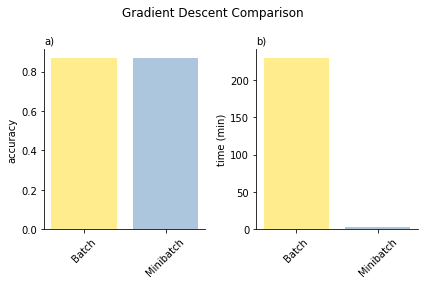

In [ ]:
acc_compare = (acc_without_mini, acc_with_mini)
time_compare = (time_without_mini, time_with_mini)

bar_data = (acc_compare, time_compare)

x = np.arange(1,3,1)
x_ticks_labels = ['Batch', 'Minibatch']
y_labels = ['accuracy', 'time (min)']
chart_labels = ['a)', 'b)']
fig, axs = plt.subplots(1, 2)

for i in range(len(axs)):

    axs[i].bar(1, bar_data[i][0], color='gold', alpha=0.45)
    axs[i].bar(2, bar_data[i][1], color='steelblue', alpha=0.45)

    axs[i].set_xticks(x)
    axs[i].set_xticklabels(x_ticks_labels, rotation=45)
    axs[i].set_title(chart_labels[i], loc='left', fontsize='medium')
    axs[i].set_ylabel(y_labels[i], fontsize=10)

fig.suptitle('Gradient Descent Comparison')
plt.tight_layout()

As seen from the graph above, the model using minibatches achieved the same accuracy at a significantly faster rate. From here on out, we'll be implementing minibatch gradient descent. However, it should also be noted that both models did suffer from type II error and labeled all the messages as ham. In the following sections, we'll see if we can overcome this issue by optimizing the model without having to adjust the prediction threshold. Towards the end, we'll conduct another comparison to confirm that using minibatches was indeed the better choice.

In [ ]:
step3()

Batch Gradient Descent
________________________
# of observations:3733
# number of hams predicted:3733


Minibatch Gradient Descent
________________________
# of observations:3733
# number of hams predicted:3733




## Step 4: Bias and Variance

Before adding in and tuning the hyperparameters, we should measure the bias and variance to get a general sense of where to start. Here, we'll compare the cost between the training and test set for a 150 epochs.

In [ ]:
params, layers = new_test(X_train, grad_check = False)

all_costs, all_accs, params, AL, all_costs_test, all_accs_test = model(X_train, y_train, params, layers, decay='none', 
                                                             interval=20, learning_rate=0.01, decay_rate=0.01, 
                                                             lambda_value=0, batch_size=64, epoch=150, 
                                                             beta1=0.9, beta2=0.999, epsilon=1e-8, 
                                                             threshold=0.5, mini = True, adam_optim = False, testing = True)

Model -> hidden layers: 2 | minibatch: True | lambda: 0 | adam: False | decay: none | lr: 0.01


epoch: 100%|██████████| 150/150 [44:04<00:00, 17.63s/it]


#### Plotting

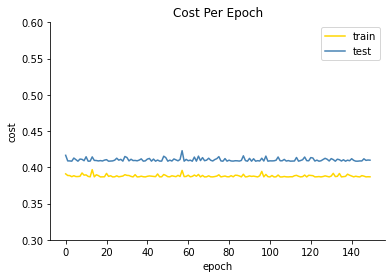

In [ ]:
train_costs, test_costs = zip(*all_costs_test)

plt.plot(train_costs, label='train', color='gold')
plt.plot(test_costs, label='test', color='steelblue')
plt.title('Cost Per Epoch')
plt.ylim(0.3, 0.6) # chose this scale to show the small oscillations and to show that bias is a little high while variance is a low
# using the default scale made it seem like both variance and bias were high
plt.xlabel('epoch')
plt.ylabel('cost')
plt.legend()
plt.show()

Although variance is relatively low—which was somewhat expected, as all the text messages are from the same inbox—there seems to be some bias. A high bias implies that the model is underfitting the data. To solve this issue, we could…    

* set TfidVectorizer's parameter 'max df' to a higher value and, or set 'min df' to a lower value to add more features  
* add more nodes to the hidden layers  
* train for more epochs

Additionally, the model seems to be learning incredibly slowly. Increasing the learning rate and training for more epochs may resolve the issue. Nonetheless, increasing the number of epochs, fine-tuning the learning rate and other hyperparameters (learning rate decay, minibatch size, etc.), may require a significant amount of time, especially with limited computational power. The best solution in this situation would be to do a broad sweep of the various possible combination of hyperparameters and optimizations without increasing the number of nodes, features, or epochs. These are the 14 scenarios we'll be testing:
1. With regularization, but no Adam optimization and learning rate decay
  1. learning rate = 0.01
  2. learning rate = 0.1
2. With regularization and learning rate decay, but no Adam optimization
  1. learning rate = 0.01
  2. learning rate = 0.1
3. With regularization and Adam optimization, but no learning rate decay
  1. learning rate = 0.01
  2. learning rate = 0.1
4. With regularization, Adam optimization and learning rate decay
  1. learning rate = 0.01
  2. learning rate = 0.1
5. With learning rate decay, but no regularization and Adam optimization
  1. learning rate = 0.01
  2. learning rate = 0.1
6. With Adam optimization, but no regularization and learning rate decay
  1. learning rate = 0.01
  2. learning rate = 0.1
7. With Adam optimization and learning rate decay, but no regularization
  1. learning rate = 0.01
  2. learning rate = 0.1

## Step 5: Broad Search

*The code below is for demonstration purposes only. Running this will take a tremendous amount of time. The values we'll be using have been gathered separately. Please refer to 'saved_data/broad_search'*

In [ ]:
pair = [(0.1, False), (0.1, True), (0, False), (0, True)]
decay_list = ['none', 'time']
lr_list = [0.01, 0.1]

directory = r'saved_data/broad_search'

for p in pair:
    for dec in decay_list:
        for lr in lr_list:
            
            if p[0] == 0 and p[1] == False and dec == 'none':
                break
                
            params, layers = new_test(X_train, grad_check = False)
            
            all_costs, all_accs, params, AL, all_costs_test, all_accs_test = model(X_train, y_train, params, layers, decay=dec, 
                                                             interval=20, learning_rate=lr, decay_rate=0.01, 
                                                             lambda_value=p[0], batch_size=64, epoch=150, 
                                                             beta1=0.9, beta2=0.999, epsilon=1e-8, 
                                                             threshold=0.5, mini = True, adam_optim = p[1], testing = True)
            
            
            o,a,c = predict(X_train, y_train, params, lambda_value=0, threshold=0.5)
            o_t,a_t,c_t = predict(X_test, y_test, params, lambda_value=0, threshold=0.5)
            
            if p[0] == 0:
                reg_label = 0
            else:
                reg_label = 1
            
            if p[1] == False:
                adam_label = 0
            else:
                adam_label = 1
            
            if dec == 'none':
                dec_label = 0
            else:
                dec_label = 1
            
            if lr == 0.01:
                lr_label = ''
            else:
                lr_label = '_lr01'
                
            filename = f'reg{reg_label}_adam{adam_label}_decay{dec_label}{lr_label}'
            
            path = os.path.join(directory, filename)
            
            with open (path, 'wb') as f:
                pickle.dump([all_costs, all_accs, params, all_costs_test, all_accs_test, o, a, c, o_t, a_t, c_t], f)

**Encoding**  
The results have been encoded using the guideline below:

* If regularization wasn't used, the first part would be "reg0", otherwise, it would be denoted as "reg1" (lambda = 0.1)  
* If Adam optimization wasn’t used, the second part would be "adam0," otherwise, it would be denoted as "adam1."  
* If a scheduled learning rate decay wasn’t used, the third part would be "decay0," otherwise, it would be denoted as "decay1."  
* If a learning rate of 0.01 was used, nothing would be added to the end, but if a learning rate of 0.1 was used, it would be denoted by "_lr01" at the end.  

So a model using regularization, Adam optimization, scheduled learning rate decay, and a learning rate of 0.01 would be denoted as "reg1_adam1_decay_1." If it used a learning rate of 0.1 it would be denoted as "reg1_adam1_decay_1_lr01."

In [ ]:
step5_1()

reg1_adam1_decay1_lr01             : (0.990624162871685, 0.9728113104948342)
reg1_adam0_decay1_lr01             : (0.8698098044468257, 0.8580750407830342)
reg1_adam0_decay0_lr01             : (0.8698098044468257, 0.8580750407830342)
reg0_adam0_decay1_lr01             : (0.8698098044468257, 0.8580750407830342)
reg1_adam0_decay1                  : (0.8698098044468257, 0.8580750407830342)
reg1_adam0_decay0                  : (0.8698098044468257, 0.8580750407830342)
reg0_adam0_decay1                  : (0.8698098044468257, 0.8580750407830342)
reg1_adam1_decay0_lr01             : (0.98928475756764, 0.9695486677542142)
reg1_adam1_decay0                  : (0.999732118939191, 0.9836867862969005)
reg0_adam1_decay0_lr01             : (0.999732118939191, 0.955410549211528)
reg0_adam1_decay1_lr01             : (0.999732118939191, 0.9717237629146275)
reg0_adam1_decay1                  : (0.999732118939191, 0.9717237629146275)
reg0_adam1_decay0                  : (0.999732118939191, 0.9554105492115

As we can see from above, the most important aspect was whether Adam optimization was used. We do see some slight variations when using different lambda values or learning rates, but the clear winner is using Adam optimization with regularization, learning rate decay and a learning rate of 0.1 (“reg1_adam1_decay1”). These results are quite impressive and surprising. Using Adam optimization allowed us to circumvent the arduous process of tuning hyperparameters.

#### 98% Accuracy

In [ ]:
step5_2()


Training Set
________________________

An accuracy of +98% for the training set was achieved at epoch 2
training accuracy was 0.9876774712027859
test accuracy was 0.9804241435562806


Test Set
________________________

An accuracy of +98% for the test set was achieved at epoch 2
training accuracy was 0.9876774712027859
test accuracy was 0.9804241435562806



#### Best Accuracy for Training and Test Set

In [ ]:
step5_3()


Training Set
________________________

The best accuracy for the training set was achieved at epoch 18
training accuracy was 0.999732118939191
test accuracy was 0.9793365959760739


Test Set
________________________

The best accuracy for the test set was achieved at epoch 83
training accuracy was 0.999732118939191
test accuracy was 0.988036976617727



### Speed and Accuracy Comparison 

Now, let’s see if using minibatch gradient descent was indeed the right choice. As seen above, the model using minibatches reached its peak test accuracy of 0.988 on the 83rd epoch. Let's see how long the model using batch gradient descent took to reach the same accuracy or better.

#### Batch Gradient Descent

*The code below is for demonstration purposes only. Running this will take a tremendous amount of time. The values we'll be using have been gathered separately. Please refer to "saved_data/compare/compare_no_mini_part2"*

In [ ]:
params, layers = new_test(X_train, grad_check = False)
v, s = adam_init(params)
learning_rate=0.1
i=0
interval = 1180 #20 epochs = 1180 iterations
decay_rate = 0.01
accuracy = 0
all_accs_grad = []

start = time.time()

while accuracy <= 0.988036976617727:
    
    if i==1000: # ideally, this should have been 4,897
        break
    
    AL, cache, cost = forward_prop(X_train, y_train, params, lambda_value =0.1)
    
    grads_new = back_prop(AL, X_train, y_train, layers, cache, lambda_value=0.1)
    
    t+=1
    
    params = update_params_adam(params, grads, v, s, t, learning_rate=learning_rate, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8)
    
    _, accuracy, _ = predict(X_train, y_train, params, lambda_value=0.1, threshold=0.5)
    
    if i % interval==0:
        
        new_lr = update_lr_time(learning_rate, i, decay_rate, interval)
        learning_rate = new_lr
    
    i+=1
    
    all_accs_grad.append(accuracy)

end = time.time()

duration_grad = (end - start)/60

#### Minibatch Gradient Descent

*The code below is for demonstration purposes only. Running this will take a tremendous amount of time. The values we'll be using have been gathered separately. Please refer to "saved_data/compare/compare_yes_mini_part2"*

In [ ]:
params, layers = new_test(X_train, grad_check = False)

start = time.time()

all_costs, all_accs_mini, params, AL, all_costs_test, all_accs_test = model(X_train, y_train, params, layers, decay='time', 
                                                 interval=20, learning_rate=0.01, decay_rate=0.01, 
                                                 lambda_value=0.1, batch_size=64, epoch=83, 
                                                 beta1=0.9, beta2=0.999, epsilon=1e-8, 
                                                 threshold=0.5, mini = True, adam_optim = True, testing = False)

end = time.time()

duration_mini = (end - start)/60

##### Plotting

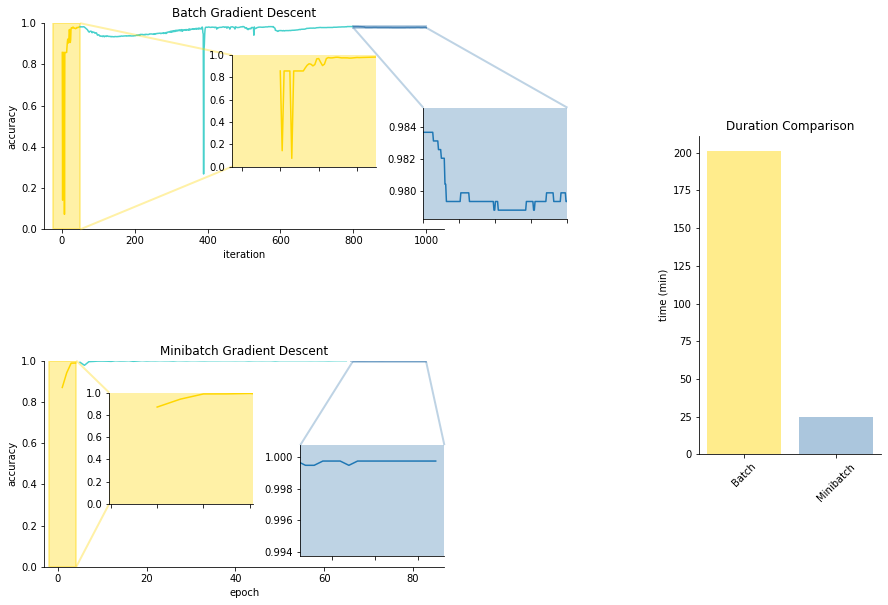

In [ ]:
step5_graph()

Using minibatch gradient descent was the better choice. For comparison, we should have run the model using batch gradient descent until it reached a test accuracy greater than or equal to 0.988 or until it iterated the same number of times the model using minibatch gradient descent updated its parameters, 4,897 times. However, with the cloud service frequently crashing, it just didn’t seem possible, but even with 1000 iterations/epochs the advantages of using minibatches are clearly illustrated: fewer oscillations, shorter duration, and higher accuracy.

## Final Step: Implement and Train

Now that we've got an idea of what works, let's train "reg1_adam1_decay_1" for 500 epochs.

*The code below is for demonstration purposes only. Running this will take a tremendous amount of time. The values we'll be using have been gathered separately. Please refer to 'saved_data/final_training'*

In [ ]:
params, layers = new_test(X_train, grad_check = False)

start = time.time()

all_costs, all_accs, params, AL, _, _ = model(X_train, y_train, params, layers, decay=0.01, 
                                                             interval=20, learning_rate=0.01, decay_rate=0.01, 
                                                             lambda_value=0.1, batch_size=64, epoch=500, 
                                                             beta1=0.9, beta2=0.999, epsilon=1e-8, 
                                                             threshold=0.5, mini = True, adam_optim = True, testing = True)
                                                             
end = time.time()

duration = (end - start)/60

In [ ]:
final_step1()


training accuracy after 500 epoch: 0.999732118939191
test accuracy after 500 epoch: 0.9853181076672104
________________________

The best accuracy for the training set was achieved at epoch 18
training accuracy was 0.999732118939191
test accuracy was 0.9793365959760739
________________________

The best accuracy for the test set was achieved at epoch 83
training accuracy was 0.999732118939191
test accuracy was 0.988036976617727



It seems like training for more epochs wasn't necessarily helpful. It may be ideal to only train for 83 epochs. Let's take a look at 5 random examples the model labeled incorrectly.

In [ ]:
final_step2(random=False) # please set random to True if you want to see more examples. 
# WARNING! You may come across some inappropriate messages. Please, do not click on any of the links.

Msg: Hello. We need some posh birds and chaps to user trial prods for champneys. Can i put you down? I need your address and dob asap. Ta r

Correct Label: spam
________________________

Msg: Back 2 work 2morro half term over! Can U C me 2nite 4 some sexy passion B4 I have 2 go back? Chat NOW 09099726481 Luv DENA Calls å£1/minMobsmoreLKPOBOX177HP51FL

Correct Label: spam
________________________

Msg: Romantic Paris. 2 nights, 2 flights from å£79 Book now 4 next year. Call 08704439680Ts&Cs apply.

Correct Label: spam
________________________

Msg: You will recieve your tone within the next 24hrs. For Terms and conditions please see Channel U Teletext Pg 750

Correct Label: spam
________________________

Msg: You can donate å£2.50 to UNICEF's Asian Tsunami disaster support fund by texting DONATE to 864233. å£2.50 will be added to your next bill

Correct Label: spam
________________________



### Testing personal text messages

I'll be feeding the network two examples from my inbox. The first is spam and the second one is ham. Feel free to test your text messages. Even if you're only testing one text message, please define it as a list.

1. 'Hungry? Get $5 off your first order on #Uber Eats with my code: eats-xinmengy2ue.'  
2. 'Yoooo where is class today?'



In [ ]:
sms=['Hungry? Get $5 off your first order on #Uber Eats with my code: eats-xinmengy2ue.', 'Yoooo where is class today?']

In [ ]:
spam_ham_filter(sms)

Label: Spam
Msg: Hungry? Get $5 off your first order on #Uber Eats with my code: eats-xinmengy2ue.

Label: Ham
Msg: Yoooo where is class today?



**Cool!**

## Conclusion and End Notes

I started this project to apply what I've learned from professor Andrew Ng's Coursera lectures and other online courses. I purposely avoided using APIs to better demonstrate my knowledge of neural networks. What I had anticipated taking, at most, 2 weeks turned into 2 and a half months. Initially, I had outlined an even larger project where I would tune the hyperparameters and compare other regularization and optimization techniques—exponential learning rate decay, batch normalization, principal component analysis (PCA), and drop-out regularization. However, I quickly realized the barriers to taking on such a large project, with the main one being time. I had tested a short script to tune the learning rate and the estimated time came out to be over a week. Thankfully, due to Adam optimization’s genius, I was able to avoid tuning hyperparameters.

If you have taken a look at “module.ipynb” and “model.ipynb,” you may have noticed that the cost function isn't embedded in the model. Originally, the cost function was called after the forward propagation function. It received the outputs from forward prop and calculated the cost, but due to an issue—which I believe was due to a rounding error caused by Numpy—gradient checking indicated something was wrong. I tested the model with a simpler 2 x 2 dataset and compared the outputs with my manual calculations, and weirdly, everything seemed to be in order. While searching for the cause, I had discovered a couple minor mistakes. My dictionary-to-vector function was flattening the parameters in the wrong order, but, to my surprise, it had no bearing on the results. Regardless, it was fixed. After two weeks of unnecessarily tinkering with my forward prop, backprop, and cost function, I found the issue and embedded the cost function inside forward propagation instead of the model. I’ve left some of the previous versions of the functions in the module for the reader’s viewing, but ulteriorly because I’m afraid to erase them.

With all the frustrations aside, I genuinely enjoyed working on this project. Through this experience, I've gained an abundance of valuable hands-on experience, not just about neural networks, but coding in general. If you have any questions about the project, or would like to provide feedback, please email me at AndrewJHPark@protonmail.com.

Thank you for reading!